In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from mp_api.client import MPRester
import ast
from ase import Atom, Atoms
from mace.calculators import mace_mp
import torch
from torch.utils.data import Dataset, DataLoader, Subset
# from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch import nn
from ase import io
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

/Users/hojechun/miniconda3/envs/krict/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.

In [3]:
from tqdm import tqdm

In [4]:
processed_df = pd.read_csv("processing_data.csv")
handcrafted_features = pd.read_csv("parsed_dataset_normalized.csv")
current_data = pkl.load(open('processed_final.pkl', 'rb'))

In [5]:
# Select columns that start with 'fp'
fp_columns = [col for col in handcrafted_features.columns if col.startswith('fp')]

# Concatenate these columns into a single feature vector column
handcrafted_features['feature_vector'] = handcrafted_features[fp_columns].apply(lambda row: np.array(row), axis=1)


In [6]:
processed_new_data_2 = {}
for key, val in current_data.items():
    if key in handcrafted_features['id'].values:
        row = processed_df[processed_df['id'] == key]
        row_2 = handcrafted_features[handcrafted_features['id'] == key]
        natoms = row['natoms'].values[0]
        value_per_atom = row['value_per_atom'].values[0]
        h_feat= row_2['feature_vector'].values[0]
        value = row["value"].values[0]
        processed_new_data_2[key] = {
            "atoms":val["atoms"],
            "descriptor":val["descriptor"],
            "descriptor_2":h_feat,
            'natoms':natoms,
            "value_per_atom": value_per_atom,
            "value":value

        }

In [7]:
pkl.dump(processed_new_data_2, open("processed_final_2.pkl", 'wb'))

In [ ]:
np.mean()

In [9]:
df = pd.read_csv('data/MatDX_EF.csv')

# Display the first few rows of the DataFrame
print(df.head())

   formula space_group                                          structure  \
0   Ni4Ta6        R-3c  [{'data': {'a': [-6.910143e-10, 0, 0], 'b': [3...   
1   Mn4Sb2    I4_1/amd  [{'data': {'a': [-1.87778212e-10, 1.87604249e-...   
2   Ir2Na2        Imma  [{'data': {'a': [-1.36776653e-10, 2.60817299e-...   
3     MoSm        R-3m  [{'data': {'a': [1.65820251e-10, 9.57363439999...   
4  Sn17P12       I-43m  [{'data': {'a': [-5.563178910000001e-10, 5.563...   

                                    id  \
0  PN_MCKVEQNTJFRUHOURCR2HCEB35KDFRETL   
1  PN_FGGHB2NFWUCYD3YZO4FWN3QVOKCTVI6K   
2  PN_BAO7ZSBZZCMA7PH7QMR7WLDI72GOELND   
3  PN_4YR2JLVZHJLC3F2TYPTOVDBJJ52C6XIE   
4  PN_H6P36AVAKDU244QNQGGCJ7YLC4A4F2YE   

                                    formation_energy  
0  {'reference': {'Ni': 'https://nomad-lab.eu/pro...  
1  {'reference': {'Mn': 'https://nomad-lab.eu/pro...  
2  {'reference': {'Na': 'https://nomad-lab.eu/pro...  
3  {'reference': {'Mo': 'https://nomad-lab.eu/pro...  
4  {'refe

In [10]:
model = mace_mp("medium")

Using Materials Project MACE for MACECalculator with /Users/hojechun/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/Users/hojechun/miniconda3/envs/krict/lib/python3.10/site-packages/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_l

In [11]:
def convert_data_to_atoms(data):
    cell = [
        [x * 1e10 for x in data['a']],
        [y * 1e10 for y in data['b']],
        [z * 1e10 for z in data['c']]
    ]
    pos = [[val['x']*10e10, val['y']*10e10, val['z']*10e10] for val in data["atoms"]]
    symbols = [val['element'] for val in data["atoms"]]
    atoms = Atoms(cell=cell, positions=pos, symbols=symbols)
    return atoms

In [12]:
new_data={}
removing_id = []
for i, structure in tqdm(enumerate(df["structure"])):
    data_id = df["id"][i]
    data = ast.literal_eval(structure)[0]
    if len(data['data'])==0:
        removing_id.append(data_id)
    else:
        atoms = convert_data_to_atoms(data['data'])
        descriptor = model.get_descriptors(atoms)
        new_data[data_id] = {"atoms": atoms, "descriptor": descriptor}
print(len(removing_id))

31it [00:02, 17.65it/s]/Users/hojechun/miniconda3/envs/krict/lib/python3.10/site-packages/matscipy/neighbours.py:718: RuntimeWarning: Ratio of simulation cell size to cutoff is very large; reducing number of bins for neighbour list search, but this may be slow. Are you using a cell with lots of vacuum?
  return ffi.neighbour_list(quantities, cell_origin, cell,
228it [00:13, 16.36it/s]


KeyboardInterrupt: 

In [14]:
atoms.todict()

{'numbers': array([29, 29, 29, 29, 29, 29, 29, 78, 78, 78, 78, 78]),
 'positions': array([[ 1.20104173e-01,  3.91846557e-01,  9.89146972e-02],
        [ 2.30562215e+01,  7.34954548e+00,  1.15055029e+01],
        [ 2.68774109e-02,  1.41758994e+01,  2.26356790e+01],
        [ 7.72185025e+00,  2.54092609e+01,  2.02858459e-01],
        [ 3.08894901e+01,  3.25806660e+01,  1.15198312e+01],
        [-1.55326963e+01,  4.69123560e+01,  3.44220683e+01],
        [-7.89956308e+00,  5.87052894e+01,  1.16107972e+01],
        [ 2.36457253e+01,  2.13968269e+01,  3.46341646e+01],
        [ 7.19044896e+00,  3.94432385e+01,  2.27144155e+01],
        [ 1.56059053e+01,  5.12111933e+01,  1.47318316e-01],
        [ 1.54272424e+01,  6.60776249e+01,  2.26431921e+01],
        [-8.16668975e+00,  7.31761278e+01,  3.47772127e+01]]),
 'cell': array([[ 4.63714115e+00, -7.22774000e-03,  4.50920000e-04],
        [-2.33060582e+00,  7.74671438e+00,  2.03848200e-02],
        [-7.72767270e-01,  2.47958020e-01,  4.57257754

In [97]:
processed_new_data = {}
for key, val in new_data.items():
    if key in processed_keys:
        row = processed_df[processed_df['id'] == key]
        natoms = row['natoms'].values[0]
        value_per_atom = row['value_per_atom'].values[0]
        value = row["value"].values[0]
        processed_new_data[key] = {
            "atoms":val["atoms"],
            "descriptor":val["descriptor"],
            'natoms':natoms,
            "value_per_atom": value_per_atom,
            "value":value

        }

In [194]:
pkl.dump(processed_new_data, open("processed_final.pkl", "wb"))

In [99]:
len(new_data), len(processed_new_data)

(4471, 4465)

In [77]:
atoms_list = [val['atoms'] for val in new_data.values()]
io.write("filtered.xyz", atoms_list)

In [14]:
class ProcessedDataDataset(Dataset):
    def __init__(self, data):
        self.data_keys = list(data.keys())
        self.data = data

    def __len__(self):
        return len(self.data_keys)

    def __getitem__(self, idx):
        data_id = self.data_keys[idx]
        sample = self.data[data_id]

        descriptor = torch.mean(torch.tensor(sample["descriptor"], dtype=torch.float32), dim=0)
        descriptor_2 = torch.tensor(sample['descriptor_2'], dtype=torch.float32)
        natoms = torch.tensor(sample["natoms"], dtype=torch.int)
        value_per_atom = torch.tensor([sample["value_per_atom"]], dtype=torch.float32)
        value = torch.tensor([sample["value"]], dtype=torch.float32)

        # Exclude atoms from the returned dictionary
        return {
            "id": data_id,
            "descriptor": descriptor,
            "descriptor_2": descriptor_2,
            "natoms": natoms,
            "value_per_atom": value_per_atom,
            "value": value
        }

In [15]:
def train_test_split_indices(dataset, test_size=0.2, random_seed=42):
    np.random.seed(random_seed)  # Set seed for reproducibility
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)  # Shuffle indices

    test_split = int(len(indices) * test_size)
    test_indices = indices[:test_split]
    train_indices = indices[test_split:]

    return train_indices, test_indices

In [30]:

# Instantiate the dataset
dataset = ProcessedDataDataset(processed_new_data_2)

# Optional: Create a DataLoader for batching
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [32]:

train_indices, test_indices = train_test_split_indices(range(len(dataset)), test_size=0.2, random_seed=42)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:


class Model(nn.Module):
    def __init__(self, feat_dim=256, n_emb=64, n_dimensions=64):
        super().__init__()
        self.mlp_emb = nn.Sequential(
            nn.Linear(feat_dim, n_dimensions),
            nn.ReLU(),
            nn.Linear(n_dimensions, n_emb),
        )
        self.mlp_fit = nn.Sequential(
            nn.Linear(n_emb, n_dimensions),
            nn.ReLU(),
            nn.Linear(n_dimensions,n_dimensions),
            nn.ReLU(),
            nn.Linear(n_dimensions, 1)
        )

    def forward(self, descriptor):
        emb = self.mlp_emb(descriptor)
        output = self.mlp_fit(emb)
        return output


In [43]:


class Model2(nn.Module):
    def __init__(self, n_emb=64, n_dimensions=64):
        super().__init__()

        self.mlp_fit = nn.Sequential(
            nn.Linear(n_emb, n_dimensions),
            nn.ReLU(),
            nn.Linear(n_dimensions,n_dimensions),
            nn.ReLU(),
            nn.Linear(n_dimensions, 1)
        )

    def forward(self, descriptor):
        # emb = self.mlp_emb(descriptor)
        output = self.mlp_fit(descriptor)
        return output


In [48]:

class Trainer:
    def __init__(self, model, train_loader, test_loader, criterion, optimizer, device='cpu'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, num_epochs=10):
        self.model.train()
        loss_list = []
        for epoch in range(num_epochs):
            total_loss = 0
            for batch in self.train_loader:
                descriptors = batch['descriptor_2'].to(self.device)  # Model input
                target = batch['value_per_atom'].to(self.device)  # Assume we are predicting 'value'

                # Forward pass
                outputs = self.model(descriptors)
                loss = self.criterion(outputs, target)  # Calculate loss based on 'value'

                # Backward and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            loss_list.append(total_loss)
            
            avg_loss = total_loss / len(self.train_loader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
            
            # Evaluate on the test set after each epoch
            test_loss = self.evaluate()
            print(f"Test Loss after Epoch [{epoch+1}/{num_epochs}]: {test_loss:.4f}")
        return loss_list

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in self.test_loader:
                descriptors = batch['descriptor_2'].to(self.device)
                target = batch['value_per_atom'].to(self.device)

                outputs = self.model(descriptors)
                loss = self.criterion(outputs, target)
                total_loss += loss.item()
        
        avg_loss = total_loss / len(self.test_loader)
        return avg_loss

In [49]:
def evaluate(model, test_loader, device):
    model.eval()
    pred_list = []
    targ_list = []
    with torch.no_grad():
        for batch in test_loader:
            descriptors = batch['descriptor_2'].to(device)
            target = batch['value_per_atom'].to(device)

            outputs = model(descriptors)
            pred_list.append(outputs)
            targ_list.append(target)
    return torch.cat(pred_list).numpy(), torch.cat(targ_list).numpy()

In [50]:
regressor = Model2()
criterion = nn.MSELoss()  # Assuming regression task
optimizer = optim.Adam(regressor.parameters(), lr=0.0001)

In [51]:
trainer = Trainer(regressor, train_loader, test_loader, criterion, optimizer, device='cuda' if torch.cuda.is_available() else 'cpu')
loss_bin = trainer.train(num_epochs=500)

Epoch [1/500], Loss: 0.4140
Test Loss after Epoch [1/500]: 0.3250
Epoch [2/500], Loss: 0.4042
Test Loss after Epoch [2/500]: 0.3181
Epoch [3/500], Loss: 0.4052
Test Loss after Epoch [3/500]: 0.3123
Epoch [4/500], Loss: 0.3995
Test Loss after Epoch [4/500]: 0.3072
Epoch [5/500], Loss: 0.3923
Test Loss after Epoch [5/500]: 0.3022
Epoch [6/500], Loss: 0.3936
Test Loss after Epoch [6/500]: 0.2985
Epoch [7/500], Loss: 0.3873
Test Loss after Epoch [7/500]: 0.2955
Epoch [8/500], Loss: 0.3855
Test Loss after Epoch [8/500]: 0.2932
Epoch [9/500], Loss: 0.3844
Test Loss after Epoch [9/500]: 0.2910
Epoch [10/500], Loss: 0.3827
Test Loss after Epoch [10/500]: 0.2886
Epoch [11/500], Loss: 0.3807
Test Loss after Epoch [11/500]: 0.2866
Epoch [12/500], Loss: 0.3789
Test Loss after Epoch [12/500]: 0.2845
Epoch [13/500], Loss: 0.3767
Test Loss after Epoch [13/500]: 0.2826
Epoch [14/500], Loss: 0.3755
Test Loss after Epoch [14/500]: 0.2803
Epoch [15/500], Loss: 0.3743
Test Loss after Epoch [15/500]: 0.278

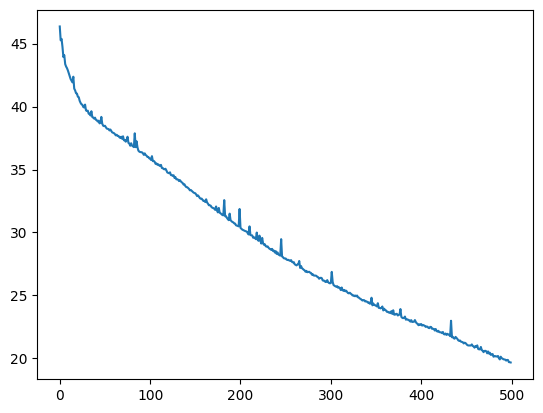

In [52]:
plt.plot(np.arange(len(loss_bin)), loss_bin)

In [55]:
pred_list, targ_list = evaluate(regressor, test_loader, "cpu")
mse = mean_squared_error(pred_list, targ_list)
mae = mean_absolute_error(pred_list, targ_list)
r2 =  r2_score(pred_list, targ_list)

Text(0, 0.5, 'Target (eV/atom)')

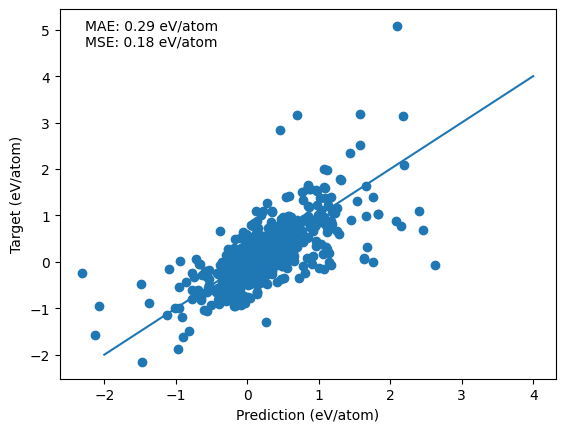

In [56]:
plt.scatter(pred_list, targ_list)
plt.plot(np.arange(-2,5), np.arange(-2,5))
# Add annotation with the correct position for MAE
plt.annotate(f"MAE: {mae:.2f} eV/atom\nMSE: {mse:.2f} eV/atom", xy=(0.05, 0.9), xycoords='axes fraction')

# plt.annotate(f"MAE: {mae:.2f} eV/atom")
# plt.annotate(f"MAE: {mae:.2f} eV/atom")
plt.xlabel("Prediction (eV/atom)")
plt.ylabel("Target (eV/atom)")